In [1]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as data
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


## Setting device training

In [2]:
# Device setting
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Setting hyper parameters for training

In [3]:
# hyper parameter
num_epochs = 10
batch_size = 128
learning_rate = 0.0001


## Set seeding function to reproduce results and set a datapath for storing data

In [4]:
# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

## Preprocessing data where we scale value of each pixel to [0:1] and calculate mean and standard deviation of 3 channels (R,G,B) for standardization

In [5]:
DATA_PATH = "../../../data"

In [6]:
train_set = datasets.CIFAR10(root=DATA_PATH, train=True, download=False)
print(train_set.data.shape)
DATA_MEAN = (train_set.data / 255.0).mean((0,1,2)) 
DATA_STD = (train_set.data / 255.0).std((0,1,2))
DATA_MEAN, DATA_STD

(50000, 32, 32, 3)


(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

## Preparing data

In [7]:
# This line of code is to auto completion of code using key "Tab". Just make coding faster ^^! 
# I read from this post "https://www.kaggle.com/getting-started/51622"
%config Completer.use_jedi = False

In [8]:
# preparing data

train_Transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(DATA_MEAN, DATA_STD),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1))
])
test_Transforms = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(DATA_MEAN, DATA_STD)])


train_dataset = datasets.CIFAR10(root=DATA_PATH, download=False, train=True,transform=train_Transforms)
val_dataset = datasets.CIFAR10(root=DATA_PATH, train=True, transform=test_Transforms, download=False)
test_dataset = datasets.CIFAR10(root=DATA_PATH, download=False, train=False,transform=test_Transforms)

# Devide train set to train and validation set with train:val = 9:1
set_seed(2910)
train_set, _ = data.random_split(train_dataset, [45000, 5000])
set_seed(2910)
_, val_set = data.random_split(val_dataset, [45000, 5000])

train_loader = DataLoader(train_set, batch_size=batch_size, 
                          shuffle=True, 
                          drop_last=True,
                          pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=True,
                         drop_last=False)
test_loader = DataLoader(val_set, batch_size=batch_size,
                         shuffle=True,
                         drop_last=False)



## Visualization

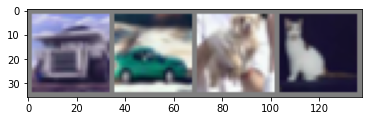

truck automobile dog   cat  


In [9]:

# Define numbers of images to show
classes = train_dataset.classes
NUM_IMGS = 4

# Define loader to read NUM_IMGS
show_loader = DataLoader(train_set, batch_size=4, shuffle=True)

# Read images
set_seed(2910)
images, labels = next(iter(show_loader))

# Create grid
imgs_grid = torchvision.utils.make_grid(images, normalize=True, pad_value = 0.5)

# Convert images to readable numpy for plt
imgs_grid =imgs_grid.numpy()

# Transform imgs to an array og images
imgs_grid = imgs_grid.transpose((1,2,0))

# Show images
plt.imshow(imgs_grid)
plt.show()

# Show labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(NUM_IMGS)))

## Inception layer

![](../../../images/inception_layer.png)

In [ ]:
class InceptionBlock(nn.Module):
    def __init__(self, c_in, c_red:dict, c_out:dict):
        """This is Inception block which flow the inception module with demension reductions

        Args:
            c_in (int): number of channel from previous layer
            c_red (dict): number of 1x1 convolution layer which is passed to 3x3 and 5x5 convolution layer afterwards
            c_out (dict): number of channel of 4 branches
        """
        super().__init__()
        
        # 1x1 branch
        self.conv_1x1 = nn.Sequential(nn.Conv2d(c_in, c_out['1x1'], kernel_sze = 1),
                                      nn.BatchNorm2d(c_out['1x1']),
                                      nn.ReLU())
        
        # 3x3 branch, we padding 1 in 3x3 convolution layer to keep same size of image
        self.conv_3x3 = nn.Sequential(nn.Conv2d(c_in, c_red['3x3'], kernel_size=1),
                                      nn.BatchNorm2d(c_red['3x3']),
                                      nn.ReLU(),
                                      nn.Conv2d(c_red['3x3'], c_out['3x3'], kernel_size=3, padding=1),
                                      nn.BatchNorm2d(c_out['3x3']),
                                      nn.ReLU())
        # 5x5 branch, we padding 2 in the 5x5 convolution layer to keep same size of image
        self.conv_5x5 = nn.Sequential(nn.Conv2d(c_in, c_red["5x5"], kernel_size=1),
                                     nn.BatchNorm2d(c_red["5x5"]),
                                     nn.ReLU(),
                                     nn.Conv2d(c_red["5x5"], c_out["5x5"], kernel_size=5, padding=2),
                                     nn.BatchNorm2d(c_out["5x5"]),
                                     nn.ReLU())        
        # Max pooling branch
        self.max_pool = nn.Sequential(nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
                                     nn.Conv2d(c_in, c_out["max"], kernel_size=1),
                                     nn.BatchNorm2d(c_out["max"]),
                                     nn.ReLU())
        
    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        output = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)
        return output    
        

## GoogLeNet

In [ ]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes = 10):
        """GoogLeNet

        Args:
            num_classes (int, optional): Number of classes in CIFAR10. Defaults to 10.
        """
        super().__init__()

        # In cifar10 conver 32x32x3 -> 32x32x64 (apply 64c kernel)
        self.input = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU())
        # Stacking inception blocks
        self.inception = nn.Sequential(
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}),
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}),
            nn.MaxPool2d(3, stride=2, padding=1),  # 32x32 => 16x16
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}),
            nn.MaxPool2d(3, stride=2, padding=1),  # 16x16 => 8x8
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}),
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16})
        )
        
        # Mapping to classification output by a fully connected layer
        self.output = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.input(x)
        x = self.inception(x)
        x = self.output(x)
        return x